# Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region using RNN models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

from utils import plot_history, plot_predictions


rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False
})

## Data Loading

In [2]:
df = pd.read_csv('data/PJMW_hourly.csv', parse_dates=['Datetime'],
                 index_col='Datetime')
df = df.resample('D').sum()
df = df.iloc[:-1]

## Data Segregation

In [3]:
ts = df.loc[:, ['PJMW_MW']].copy()
trainval, holdout = ts.iloc[:-365], ts.iloc[-365:]
train, val = trainval.iloc[:-365], trainval.iloc[-365:]

In [4]:
num_train_samples = len(train)
num_val_samples = len(val)

In [5]:
normalized = (ts - train.mean()) / train.std()

## Data Preparation

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# Configuration parameters
sampling_rate = 1 # data is already sampled per day, thus this is 1
ahead = 30 # number of days ahead to forecast
sequence_length = 30 # how many days in history to use as predictors
delay = sampling_rate * (sequence_length + ahead - 1)
batch_size = 256

In [8]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    normalized.iloc[:-delay],
    targets=normalized['PJMW_MW'].to_numpy()[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    normalized.iloc[:-delay],
    targets=normalized['PJMW_MW'].to_numpy()[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    normalized.iloc[:-delay],
    targets=normalized['PJMW_MW'].to_numpy()[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

## Model Training and Evaluation

### LSTM

In [9]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(256, return_sequences=True)(inputs)
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.LSTM(256)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,073 (5.02 MB)

 Trainable params: 1,315,073 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint(f'models/LSTM.keras', save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mape', 'mse'])

In [12]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.9654 - mae: 0.7946 - mape: 230.8985 - mse: 0.9654 - val_loss: 0.8728 - val_mae: 0.7664 - val_mape: 113.5552 - val_mse: 0.8728
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8670 - mae: 0.7505 - mape: 246.1776 - mse: 0.8670 - val_loss: 0.9697 - val_mae: 0.8001 - val_mape: 160.9287 - val_mse: 0.9697
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8655 - mae: 0.7458 - mape: 289.5609 - mse: 0.8655 - val_loss: 0.8557 - val_mae: 0.7491 - val_mape: 133.8763 - val_mse: 0.8557
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8406 - mae: 0.7308 - mape: 326.8577 - mse: 0.8406 - val_loss: 0.8581 - val_mae: 0.7478 - val_mape: 135.5332 - val_mse: 0.8581
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8482 - mae: 0.7339 - mape: 473.6940 - mse: 0.8482 - val_loss: 0.9295 - val_mae: 0.7548 - val_mape: 162.0751 - val_mse: 0.9295
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9019

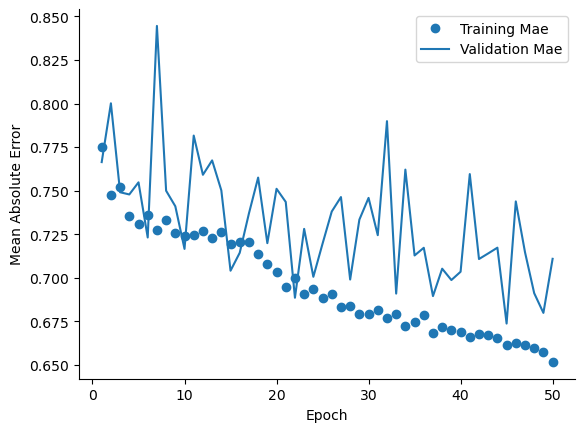

In [13]:
fig, ax = plot_history(history, 'mae')

In [14]:
model = keras.models.load_model("models/LSTM.keras")
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9709 - mae: 0.7164 - mape: 349.2048 - mse: 0.9709 


[0.9555769562721252, 0.711773157119751, 347.2446594238281, 0.9555769562721252]

In [15]:
actuals = []
predictions = []
for samples, targets in test_dataset:
    actuals.extend(targets)
    predictions.extend(model.predict(samples))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


In [16]:
actuals = np.array([float(actual) for actual in actuals])
actuals = actuals*train.to_numpy().std() + trainval.to_numpy().mean()
predictions = np.array([float(target) for target in predictions])
predictions = predictions*trainval.to_numpy().std() + trainval.to_numpy().mean()

/tmp/ipykernel_76495/4142552982.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions = np.array([float(target) for target in predictions])


In [17]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
lstm_performances = []
metrics = {'MAE': mean_absolute_error,
           'MSE': mean_squared_error,
           'MAPE': mean_absolute_percentage_error,}
for metric in metrics.values():
    lstm_performances.append({
        'LSTM': metric(actuals, predictions),
    })

In [19]:
pd.DataFrame(lstm_performances, index=metrics.keys())

,LSTM
MAE,1.258552e+04
MSE,2.987862e+08
MAPE,8.842125e-02


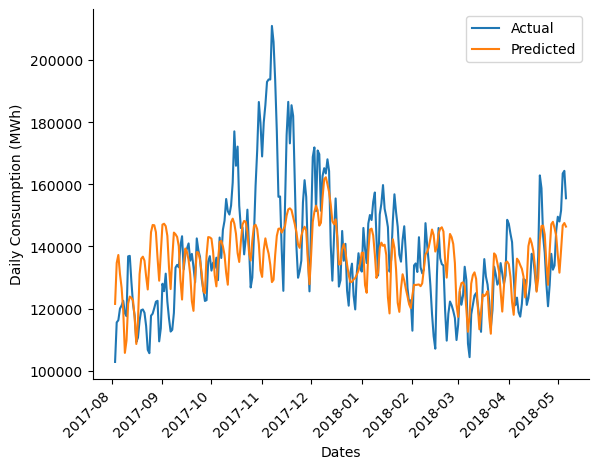

In [22]:
plot_predictions(actuals, predictions, dates=holdout.index[:len(predictions)])
plt.xticks(rotation=45, ha='right');

### GRU

In [23]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.GRU(256, return_sequences=True)(inputs)
x = layers.GRU(256, return_sequences=True)(x)
x = layers.GRU(256)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 30, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 988,673 (3.77 MB)

 Trainable params: 988,673 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Model checkpointing
callbacks = [
    keras.callbacks.ModelCheckpoint(f'models/GRU.keras', save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mape', 'mse'])

In [26]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.0165 - mae: 0.8099 - mape: 269.8509 - mse: 1.0165 - val_loss: 0.9177 - val_mae: 0.7898 - val_mape: 130.7756 - val_mse: 0.9177
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.9256 - mae: 0.7717 - mape: 278.8215 - mse: 0.9256 - val_loss: 0.8922 - val_mae: 0.7715 - val_mape: 135.0182 - val_mse: 0.8922
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9080 - mae: 0.7649 - mape: 257.2646 - mse: 0.9080 - val_loss: 0.9122 - val_mae: 0.7885 - val_mape: 120.9598 - val_mse: 0.9122
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.9020 - mae: 0.7645 - mape: 260.9960 - mse: 0.9020 - val_loss: 0.8694 - val_mae: 0.7645 - val_mape: 114.3500 - val_mse: 0.8694
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9107 - mae: 0.7653 - mape: 289.1566 - mse: 0.9107 - val_loss: 0.9289 - val_mae: 0.7837 - val_mape: 138.7471 - val_mse: 0.9289
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9178

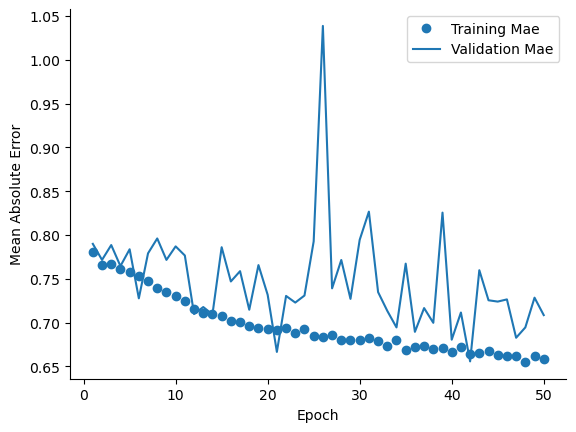

In [27]:
fig, ax = plot_history(history, 'mae')

In [28]:
model = keras.models.load_model("models/GRU.keras")
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9984 - mae: 0.7183 - mape: 340.5601 - mse: 0.9984 


[0.9837654232978821, 0.7135283350944519, 338.5920715332031, 0.9837654232978821]

In [29]:
actuals = []
predictions = []
for samples, targets in test_dataset:
    actuals.extend(targets)
    predictions.extend(model.predict(samples))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


In [30]:
actuals = np.array([float(actual) for actual in actuals])
actuals = actuals*train.to_numpy().std() + trainval.to_numpy().mean()
predictions = np.array([float(target) for target in predictions])
predictions = predictions*trainval.to_numpy().std() + trainval.to_numpy().mean()

/tmp/ipykernel_76495/4142552982.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions = np.array([float(target) for target in predictions])


In [31]:
gru_performances = []
metrics = {'MAE': mean_absolute_error,
           'MSE': mean_squared_error,
           'MAPE': mean_absolute_percentage_error,}
for metric in metrics.values():
    gru_performances.append({
        'GRU': metric(actuals, predictions),
    })

In [32]:
pd.DataFrame(gru_performances, index=metrics.keys())

,GRU
MAE,1.261628e+04
MSE,3.075810e+08
MAPE,8.755377e-02


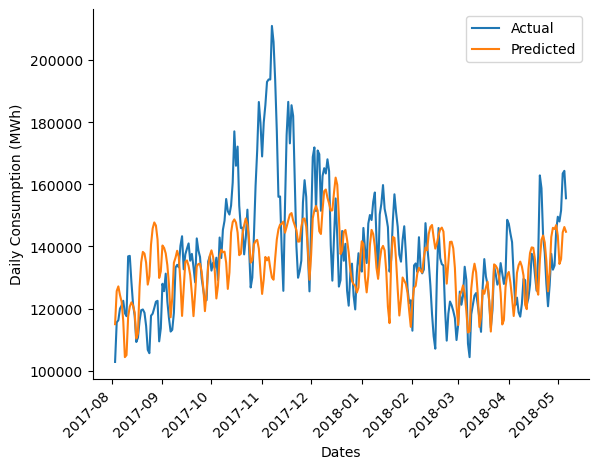

In [35]:
fig, ax = plot_predictions(
    actuals, predictions,
    dates=holdout.index[:len(predictions)])
plt.xticks(rotation=45, ha='right');

In [34]:
pd.DataFrame(
    lstm_performances, index=metrics.keys()).to_csv('results/lstm.csv')
pd.DataFrame(
    gru_performances, index=metrics.keys()).to_csv('results/gru.csv')